In [1]:
import tensorflow as tf
from truesight.preprocessing import Preprocessor
from truesight.core import TrueSight
from truesight.metrics import Evaluator, mse, rmse, mae
from truesight.utils import get_input_shapes, generate_syntetic_data

Generate syntetica data for training and testing the model

In [28]:
num_time_steps = 100
seasonal_lenght = 12
forecast_horizon = 12
df = generate_syntetic_data(num_time_steps, seasonal_lenght, num_series=100)

The preprocessor class takes a dataframe with the columns the following columns:

 - unique_id: A string that uniquely identifies each time series in the dataframe
 - ds: A datetime column with the date of each time step. The dates must be in the correct frequency for the date_freq parameter
 - y: The values of the time series

You can include as many statistical models as needed in the model's parameter as long as it follows the statsforecast syntax. However, more models would result in a longer processing time. It is essential to set a fallback_model in case any of the informed models fail to fit.

In [29]:
from statsforecast.models import SeasonalNaive, AutoETS
from truesight.models import AdditiveDecomposition

preprocessor = Preprocessor(df)
X_train, Y_train, ids_train, X_val, Y_val, ids_val, models = preprocessor.make_dataset(
    forecast_horizon = 12, 
    season_length = 12,
    date_freq = "MS", 
    models = [AdditiveDecomposition, AutoETS, SeasonalNaive], 
    fallback_model = SeasonalNaive,
    verbose = True
    )

100%|██████████| 20/20 [00:01<00:00, 18.62it/s]


Create the model

In [30]:
input_shapes = get_input_shapes(X_train)
truesight = TrueSight(models, input_shapes, forecast_horizon = forecast_horizon)

Use the `auto_tune` to automatically define the hyperparameters

In [31]:
truesight.auto_tune(X_train, Y_train, X_val, Y_val, n_trials = 10, batch_size = 512, epochs = 5)

Or set then manually

In [ ]:
truesight.set_hparams(lstm_units=256, hidden_size=1024, num_heads=8, dropout_rate=0.1)

Train the model

INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets


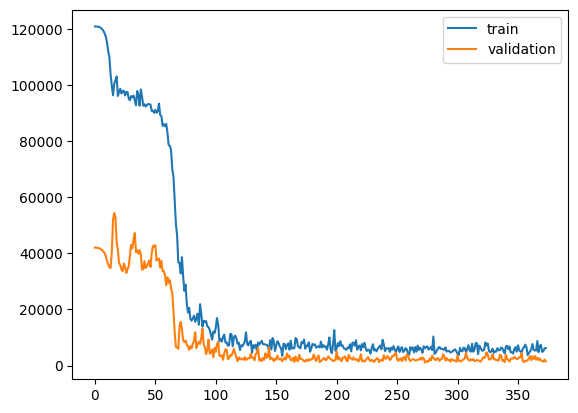

In [32]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 100, restore_best_weights = True, monitor = "val_loss"),
    tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.5, patience = 25, verbose = False),
]
truesight.fit(X_train, Y_train, X_val, Y_val, batch_size = 128, epochs = 1000, verbose = False, callbacks = callbacks)
truesight.plot_history()

Evaluate the results

In [50]:
Y_hat = truesight.predict(X_val, batch_size = 500, n_repeats = 100, n_quantiles = 15, return_quantiles = True, verbose = False)
evaluator = Evaluator(X_val, Y_val, Y_hat, ids_val)
print(evaluator.evaluate_prediction([mse, rmse, mae], return_mean=False).to_markdown())

|    |         mse |      rmse |      mae |
|---:|------------:|----------:|---------:|
| 10 |  1164.51    |  34.1249  | 25.9397  |
| 13 |     2.91094 |   1.70615 |  1.69313 |
| 18 |     2.62309 |   1.6196  |  1.5549  |
| 38 |     2.77819 |   1.66679 |  1.62896 |
| 45 |   892.701   |  29.8781  | 10.0897  |
| 46 |     2.96284 |   1.72129 |  1.71549 |
| 50 |  3585.54    |  59.8794  | 49.0362  |
| 51 | 12199.1     | 110.449   | 93.9491  |
| 53 |     2.6345  |   1.62311 |  1.56625 |
| 54 |     2.77184 |   1.66488 |  1.63493 |
| 61 |   303.464   |  17.4202  | 14.6694  |
| 67 |     2.70393 |   1.64436 |  1.60988 |
| 69 |  2578.09    |  50.7749  | 38.986   |
| 70 |     3.09074 |   1.75805 |  1.75805 |
| 73 |     2.80945 |   1.67614 |  1.65109 |
| 75 |     2.88333 |   1.69804 |  1.68085 |
| 78 |     3.09091 |   1.7581  |  1.7581  |
| 81 |     2.64539 |   1.62647 |  1.56712 |
| 83 |   491.263   |  22.1644  | 18.4432  |
| 86 |     2.84002 |   1.68523 |  1.64177 |


Visualize individual inputs

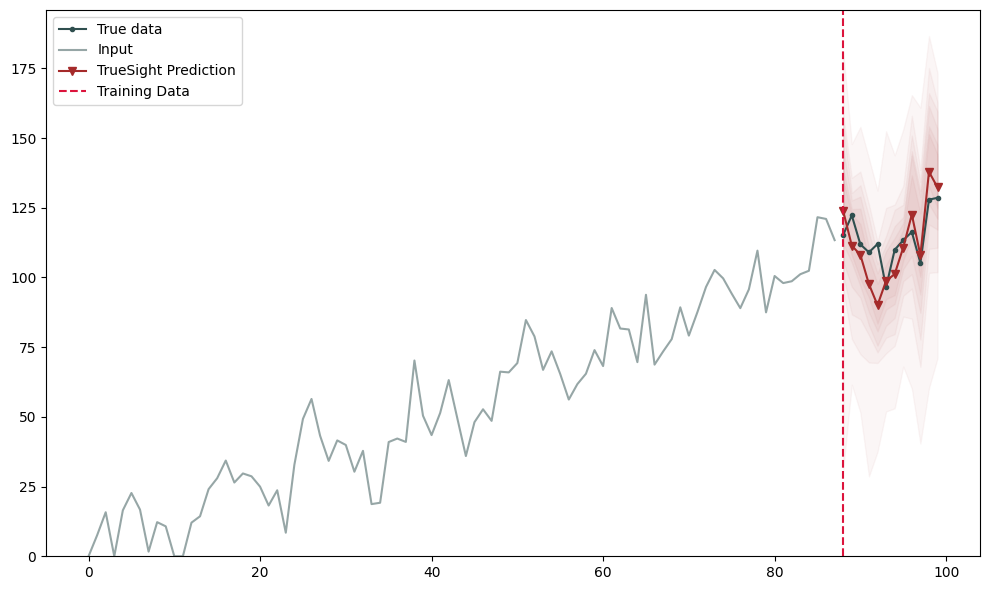

In [48]:
evaluator.plot_exemple()